In [1]:
import thermo
from thermo.chemical import Chemical

In [2]:
import math
import fluids
from fluids.units import *

Given:  Water at 70 degF is pumped through the piping system at a rate of 100 gallons per minute.
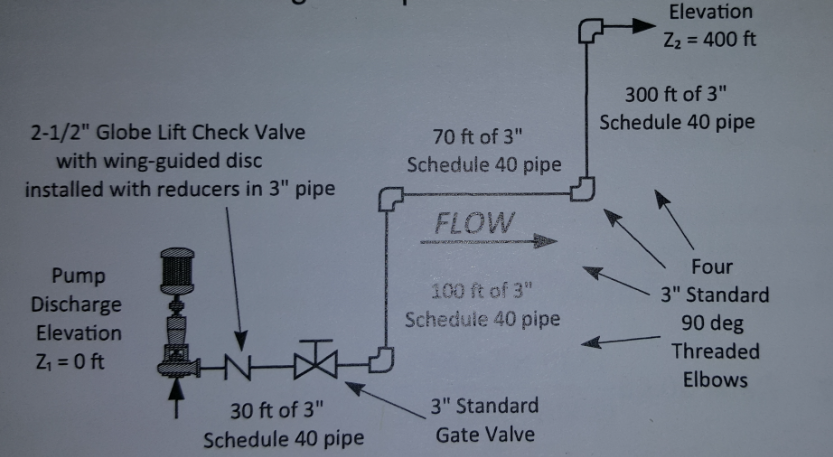
Find:  The total discharge head (H) at flowing conditions and the brake horsepower (bhp) required for a pump having an efficiency (nu_p) of 70%.

In [3]:
T = (70*u.degF).to(u.degK)

Assume atmospheric pressures

In [4]:
P = (1*u.atm).to(u.Pa)

Get the water properties from PubChem

In [5]:
water = Chemical('water', P=P.magnitude, T=T.magnitude)

# Solve using the fluids-built in functions exclusively

Only the following types of clean, new pipe have data available:
‘Plastic coated’
‘Carbon steel, honed bare’
‘Cr13, electropolished bare’
‘Cement lining’
‘Carbon steel, bare’
‘Fiberglass lining’
‘Cr13, bare’

In [6]:
mu = (water.mu*u.Pa*u.sec).to(u.cP)
rho = (water.rho*u.kilogram/u.meter**3).to(u.lb/u.feet**3)
d = (nearest_pipe(NPS=3*u.inch, schedule='40')[1]).to(u.inch)
g = 32.2*u.feet/u.second**2
Q = 100*u.gallons/u.min

ft = 0.017 #Crane 410, A-27

mu, rho, d, Q, ft

(<Quantity(0.9958722059415758, 'centipoise')>,
 <Quantity(62.337975431490435, 'pound / foot ** 3')>,
 <Quantity(3.067716535433071, 'inch')>,
 <Quantity(100.0, 'gallon / minute')>,
 0.017)

Pump head H is the pressure terms in the Bernoulli equation.  A pump is a pressure booster:
H = 144/rhp*(P1-P2)

# Solve for Ks

In [7]:
#90 degree elbows, qty = 4
K_elbow = 30 *ft #90 deg Elbows, Crane 410, A-30

K_elbows = 4 *K_elbow

K_elbows

2.04

In [8]:
# gate valve
K_gate = 8 * ft #Crane 410, A-28

K_gate 

0.136

In [9]:
# 2-1/2" Lift Check Valve.  Crane 410 solution ignores the reducers K
d1 = (nearest_pipe(NPS=2.5*u.inch, schedule='40')[1]).to(u.inch) #assuming check valve is same id as 2" pipe

beta = d1/d

ft_2_5 = 0.018 #Crane 410, A-28

K1 = 600*ft_2_5

K2 = (K1 + beta*(0.5*(1-beta**2) + (1-beta**2)**2))/beta**4

#Reducers
K2_red = 1.5*(1-d1**2/(d**2))**2

K2_red, K2

(<Quantity(0.1868254594419049, 'dimensionless')>,
 <Quantity(26.371383304848667, 'dimensionless')>)

Can see why effects of control valve reducers is ignored by Crane 410.  The reducer friction is much less than the friction of the valve

In [10]:
#Straight pipe
L = 500*u.feet #of 3" pipe
D = d

v = 0.4085*Q/d**2  #Crane 410, page 6-2

Re = (123.0*d*v*rho/mu).magnitude*u.dimensionless

e = roughness_Farshad('Carbon steel, bare', D=d.to(u.meter))
f = friction_factor(Re=Re, eD=e/d.to(u.meter))  #friction factor for 2-1/2" pipe

K_pipe = f*L/(D.to(u.feet))

K_pipe

<Quantity(39.22523865791324, 'dimensionless')>

In [11]:
#K total
Ktot = K_pipe + K2_red + K2 + K_gate + K_elbows

Ktot

<Quantity(67.95944742220381, 'dimensionless')>

# Pump head H is the pressure terms in the Bernoulli equation.  A pump is a pressure booster: H = 144/rhp*(P1-P2)

In [12]:
hL = (0.002593*Ktot*Q**2/(d**4)).magnitude*u.feet

hL

<Quantity(19.897176239612488, 'foot')>

In [13]:
HdeltaZ = 400*u.feet

HdeltaV = 0*u.feet #since pipe is same diameter the velocity does not change

H = HdeltaZ + HdeltaV + hL

H

<Quantity(419.89717623961246, 'foot')>

In [14]:
#bhp at 70% efficiency
nu_p = 0.70 #pump efficiency

bhp = (Q*H*rho/(247000*nu_p)).magnitude*u.horsepower

'{:.2f}'.format(bhp)

'15.14 horsepower'